# Deep Learning on Ancient DNA

https://towardsdatascience.com/deep-learning-on-ancient-dna-df042dc3c73d

In [1]:
import os
import pysam
import numpy as np
#os.chdir('/media/nikolay/My Book Duo/AncientDNA/')

In [2]:
DIR_ROOT = '../data/bioinformatics/neandertal/Deep_Learning_on_Ancient_DNA/'
!ls -al $DIR_ROOT
CONTIGS_DIR = DIR_ROOT + 'Neandertal_Sequence_Contigs_Generated_by_Genotype_Caller/Human_hg18/'
SEQUENCE_DIR = DIR_ROOT + 'Neandertal_Sequence_Reads/Human_hg18/'
FRENCH_DIR = DIR_ROOT + 'Alignments_of_Sequence_Reads_from_5_Modern_Humans/Human_hg18/'
!ls -al $CONTIGS_DIR
!ls -al $SEQUENCE_DIR

# Read Bam or Fastq file (it does not have to be Bam)
#neand = pysam.AlignmentFile("Neandertal.bam", "rb")
#FILE = CONTIGS_DIR + "all-hg18.bam"
#FILE = CONTIGS_DIR + "Vi33.25-hg18.bam"
#FILE = CONTIGS_DIR + "Vi33.26-hg18.bam"
#FILE = SEQUENCE_DIR + "SLMez1.hg18.bam"
#FILE = SEQUENCE_DIR + "SLVi33.25.hg18.bam"
FILE = SEQUENCE_DIR + "SLVi33.26.hg18.bam"
FRENCH_FILE = SEQUENCE_DIR + "SLVi33.26.hg18.bam"
#FILE = FRENCH_DIR + "MMS8_HGDP00521_French.paired.qualfilt.rmdup.entropy1.0.sort.bam"
print(f'FILE: [{FILE}]')
! ls -al $FILE
neand = pysam.AlignmentFile(FILE, "rb")

total 24
drwxrwxr-x 5 dave dave 4096 Sep 16 20:26 .
drwxrwxr-x 6 dave dave 4096 Sep 16 17:06 ..
drwxrwxr-x 3 dave dave 4096 Sep 16 20:26 Alignments_of_Sequence_Reads_from_5_Modern_Humans
drwxrwxr-x 3 dave dave 4096 Sep 16 18:13 Neandertal_Sequence_Contigs_Generated_by_Genotype_Caller
drwxrwxr-x 3 dave dave 4096 Sep 16 18:15 Neandertal_Sequence_Reads
-rw-rw-r-- 1 dave dave 1042 Sep 16 16:59 readme
total 5780924
drwxrwxr-x 2 dave dave       4096 Sep 16 18:14 .
drwxrwxr-x 3 dave dave       4096 Sep 16 18:13 ..
-rw-rw-r-- 1 dave dave 1650448558 Sep 16 16:48 all-hg18.bam
-rw-rw-r-- 1 dave dave    6843080 Sep 16 17:24 all-hg18.bam.bai
-rw-rw-r-- 1 dave dave 1878104919 Sep 16 17:00 all-hg18.fasta
-rw-rw-r-- 1 dave dave    1699436 Sep 16 18:02 Feld1-hg18.bam
-rw-rw-r-- 1 dave dave    1758112 Sep 16 18:02 Feld1-hg18.bam.bai
-rw-rw-r-- 1 dave dave   40602746 Sep 16 18:03 Mez1-hg18.bam
-rw-rw-r-- 1 dave dave    5422544 Sep 16 18:03 Mez1-hg18.bam.bai
-rw-rw-r-- 1 dave dave    1667188 Sep 16 18:03 

In [3]:
# Record length of each DNA sequence
iter = neand.fetch("chr2", 0, 249000000)
neand_lengths = []
for i in iter:
    neand_lengths.append(i.infer_query_length())

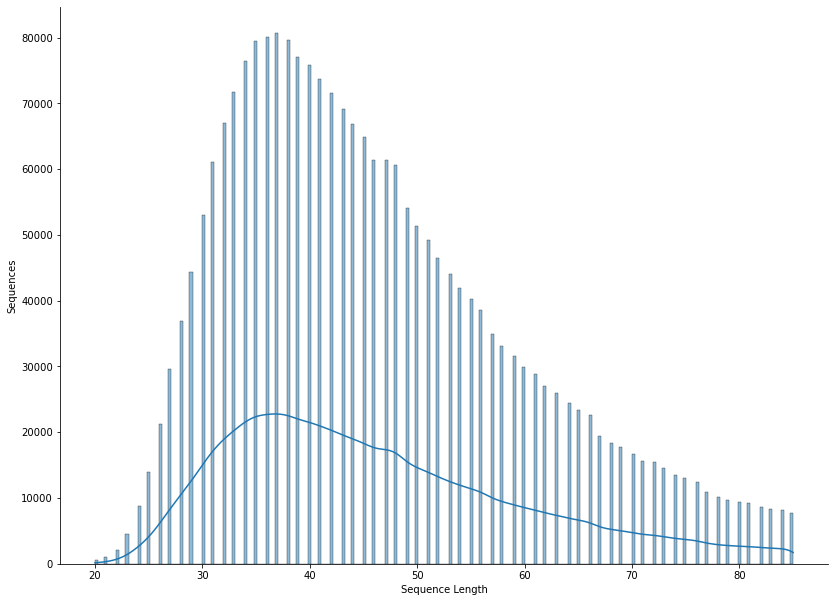

In [4]:
# Plot distribution of DNA read lengths
import seaborn as sns
import matplotlib.pyplot as plt
aplot=sns.displot(height=8.27, aspect=11.7/8.27, data=neand_lengths, kde=True).set_axis_labels("Sequence Length", "Sequences")
#aplot.set(xlim=(0,100))
plt.show()

In [5]:
# Extract 76 nt ancient DNA sequances
neand_seqs = []
for j in range(1,11):
    iter = neand.fetch('chr' + str(j))
    for i in iter:
        if i.infer_query_length() == 76:
            s = str(i.get_forward_sequence())
            if s.count('A')>0 and s.count('C')>0 and s.count('G')>0 and s.count('T')>0 and 'N' not in s:
                neand_seqs.append(i.get_forward_sequence())

# Read modern DNA sample
modern = pysam.AlignmentFile(FRENCH_FILE, "rb")
modern_seqs = []
for j in range(1,11):
    iter = modern.fetch("chr" + str(j))
    for i in iter:
        if len(modern_seqs) == len(neand_seqs):
            break
        else:
            s = str(i.get_forward_sequence())
            if s.count('A')>0 and s.count('C')>0 and s.count('G')>0 and s.count('T')>0 and 'N' not in s:
                modern_seqs.append(i.get_forward_sequence())
sequences = neand_seqs + modern_seqs
labels = list(np.ones(len(neand_seqs))) + list(np.zeros(len(modern_seqs)))

In [6]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# One-hot encode Sequences
integer_encoder = LabelEncoder()  
one_hot_encoder = OneHotEncoder()   
input_features = []
for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

# One-hot encode Labels
one_hot_encoder = OneHotEncoder()
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()
print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.25, random_state=42)

ValueError: all input arrays must have the same shape